# Contextual Text Classification

RNN based sentiment analysis on dataset of plain-text IMDB movie reviews.

In [1]:
import os
import re
import string
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.__version__

'2.7.0'

## Prepare data

In [2]:
os.listdir("/database/tensorflow-datasets/")

['movielens', 'datasets', 'tiny_shakespeare', 'imdb_reviews', 'downloads']

In [3]:
# Load data
dataset, info = tfds.load(
    name="imdb_reviews",
    with_info=True,
    as_supervised=True,
    data_dir="/database/tensorflow-datasets/"
)
train_dataset, test_dataset = dataset["train"], dataset["test"]

2021-12-11 21:52:58.661752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 21:52:58.665988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 21:52:58.666471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 21:52:58.667164: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
for review, label in train_dataset.take(1).as_numpy_iterator():
    print("Review;", review, "Label:", label)

Review; b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." Label: 0


2021-12-11 21:52:59.304319: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
for review, label in test_dataset.take(1).as_numpy_iterator():
    print("Review;", review, "Label:", label)

Review; b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come." Label: 1


2021-12-11 21:52:59.491458: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
type(train_dataset), type(test_dataset)

(tensorflow.python.data.ops.dataset_ops.PrefetchDataset,
 tensorflow.python.data.ops.dataset_ops.PrefetchDataset)

In [7]:
# Create an optimized dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Create text encoder

In [8]:
VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 512
EMBEDDING_DIM = 100

# Custom text processor
def text_processor(input_data):
    lowercase_text = tf.strings.lower(input_data)
    stripped_text = tf.strings.regex_replace(lowercase_text, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_text, "[%s]" % re.escape(string.punctuation), ""
    )

# Encoder layer
encoder_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=text_processor,
    split="whitespace",
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Learn the encoder layer
encoder_layer.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocabulary = np.array(encoder_layer.get_vocabulary())

In [10]:
print("Top 20 vocabulary:", vocabulary[:20]) # Most frequent

Top 20 vocabulary: ['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'was' 'as' 'for' 'with' 'movie' 'but' 'film']


In [11]:
print("Bottom 20 vocabulary:", vocabulary[-20:]) # Least frequent

Bottom 20 vocabulary: ['acid' '35' '1971' 'wouldbe' 'voiced' 'victory' 'uplifting' 'unseen'
 'unfair' 'tooth' 'technicolor' 'survivor' 'stunned' 'sounding' 'sid'
 'screens' 'rolled' 'resulting' 'reflection' 'ramones']


## Implement model architecture

In [12]:
def get_bilstm_model():
    model = tf.keras.Sequential()
    model.add(encoder_layer)
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model

## Learn and evaluate model

In [13]:
# Get model
model = get_bilstm_model()

# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

# Learn
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)]
)

Epoch 1/10


2021-12-11 21:53:12.030149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


391/391 [==============================] - 72s 161ms/step - loss: 0.4649 - accuracy: 0.7584 - val_loss: 0.5042 - val_accuracy: 0.7816
Epoch 2/10
391/391 [==============================] - 60s 154ms/step - loss: 0.3107 - accuracy: 0.8683 - val_loss: 0.3322 - val_accuracy: 0.8748
Epoch 3/10
391/391 [==============================] - 60s 154ms/step - loss: 0.2235 - accuracy: 0.9119 - val_loss: 0.3791 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 60s 154ms/step - loss: 0.1718 - accuracy: 0.9333 - val_loss: 0.2912 - val_accuracy: 0.8857
Epoch 5/10
391/391 [==============================] - 60s 154ms/step - loss: 0.1251 - accuracy: 0.9528 - val_loss: 0.3405 - val_accuracy: 0.8803
Epoch 6/10
391/391 [==============================] - 60s 153ms/step - loss: 0.0914 - accuracy: 0.9678 - val_loss: 0.3759 - val_accuracy: 0.8816


In [14]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Loss:", test_loss, "Test Accuracy:", test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3759 - accuracy: 0.8816
Test Loss: 0.3758942484855652 Test Accuracy: 0.8815600275993347


## Plot model performance

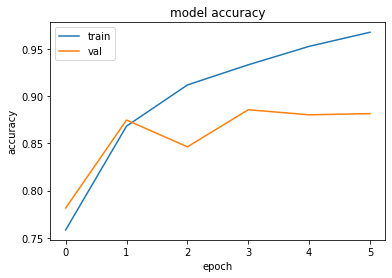

In [15]:
# Model accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

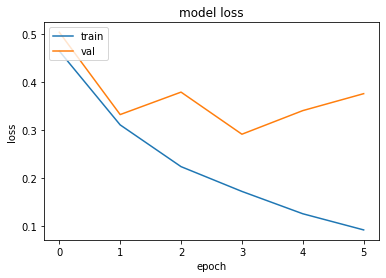

In [16]:
# Model loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

## Generate predictions

In [17]:
sample_text = ("The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.")

predictions = model.predict(np.array([sample_text]))
label_predicted = "Positive" if predictions[0][0] >= 0.0 else "Negative"

print("Review:", sample_text)
print("Predicted Label:", label_predicted)

Review: The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.
Predicted Label: Negative
